In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load traffic data
data = pd.read_csv("data.csv", index_col=0)
agg_mat_df = pd.read_csv("agg_mat.csv", index_col=0)

maximum = np.max(data.values)
data_scaled = (data / maximum).values

seed = 0 

def set_seeds(seed): 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # if using nvidia gpu
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

set_seeds(seed)

In [3]:
n_series = data.shape[1] 
n_total = data.shape[0]
n_train = 230
context_window = 5
n_val = 50

data.shape

(366, 207)

In [4]:
def calculate_wmape(actual_values, forecasted_values):
    # compute wMAPE metric
    n = len(actual_values)
    num = np.sum(np.abs(actual_values - forecasted_values))
    den = np.sum(np.abs(actual_values))
    wmape = num/den
    return wmape

def calculate_RMSE(actual_values, forecasted_values): 
    # compute RMSE metric
    squared_errors = (actual_values - forecasted_values) ** 2
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350'),
  Text(400.0, 0, '400')])

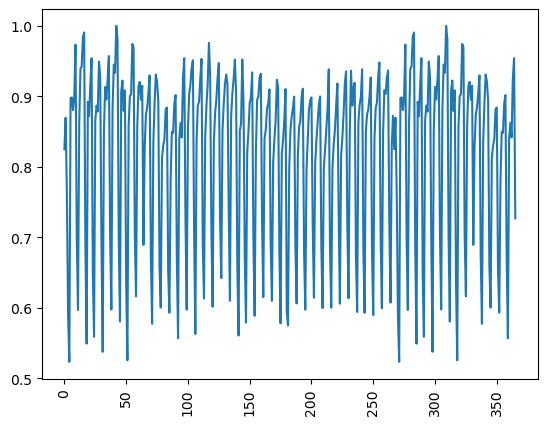

In [5]:
plt.plot(data_scaled[:,0])
plt.xticks(rotation=90)

In [6]:
def make_data(dataset, range_, context_window): 
    # produces X_data and y_data tensors given the dataset 
    X_data = []
    y_data = []
    for i in range_:
        X = dataset[i:i+context_window,:].T.flatten()
        X_data.append(X)

        y = dataset[i+context_window:i+context_window+1,:].T.flatten()
        y_data.append(y)

    return torch.tensor(X_data, dtype=float), torch.tensor(y_data, dtype=float)

In [7]:
class Dataset_Traffic(Dataset):
    def __init__(self, root_path, flag='train', data_path='data.csv', context_window=5, n_train=n_train, n_val=n_val, seq_len=n_train-context_window):
        
        # init
        self.root_path = root_path
        self.data_path = data_path
        self.context_window=context_window
        self.n_train = n_train
        self.n_val = n_val
        self.seq_len = seq_len
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path), index_col=0)
        maximum = np.max(df_raw.values)
        data = (df_raw / maximum).values
        
        X_data = []
        y_data = []

        if self.set_type == 0: 
            data_range = range(self.n_train)
        elif self.set_type == 1: 
            data_range = range(self.n_train, self.n_train + self.n_val)
        else: 
            data_range = range(self.n_train + self.n_val, self.data.shape[0] - self.context_window)

        for i in data_range:
            X = data[i:i+self.context_window,:].T.flatten()
            X_data.append(X)

            y = data[i+self.context_window:i+self.context_window+1,:].T.flatten()
            y_data.append(y)

        self.X = torch.tensor(np.array(X_data))
        self.y = torch.tensor(np.array(y_data))

    def __getitem__(self, index):
        X = self.X[index:index + self.seq_len, :]
        y = self.y[index:index + self.seq_len]
        
        return X, y

    def __len__(self):
        return len(self.X) - context_window - self.seq_len + 1

In [8]:
train_dataset = Dataset_Traffic('/home/gridsan/mhensgen/traffic', seq_len=50)

In [9]:
train_dataset.X.dtype

torch.float64

In [10]:
X_train, y_train = make_data(data_scaled, range(n_train), context_window)
X_val, y_val = make_data(data_scaled, range(n_train, n_train+n_val), context_window)
X_test, y_test = make_data(data_scaled, range(n_train + n_val,n_total - context_window), context_window)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([230, 1035])
torch.Size([50, 1035])
torch.Size([81, 1035])


/state/partition1/slurm_tmp/25964723.0.0/ipykernel_2515371/3169270821.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(X_data, dtype=float), torch.tensor(y_data, dtype=float)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

aggregation_mat = torch.tensor(np.append(np.zeros((agg_mat_df.shape[0], agg_mat_df.shape[0] - agg_mat_df.shape[1])), agg_mat_df, axis=1), dtype=float).to(device)
S = agg_mat_df.values

def coherency_loss(network): 
    # computes coherency on last layer of the network 
    repeated_bias = network.last_layer.bias.repeat(network.last_layer.weight.shape[0], 1)
    return torch.norm(aggregation_mat @ network.last_layer.weight - network.last_layer.weight) + torch.norm(
        aggregation_mat @ network.last_layer.bias - network.last_layer.bias) 

def coherency_metric(predictions):
    # computes the actual coherency of predictions 
    return torch.norm(predictions.T - aggregation_mat @ predictions.T) / predictions.shape[1]

def create_M(S): 
    # creates the projection matrix M given the aggregation matrix S
    m, m_K = S.shape
    m_agg = m-m_K

    # The top `m_agg` rows of the matrix `S` give the aggregation constraint matrix.
    S_agg = S[:m_agg, :]
    A = np.hstack((np.eye(m_agg), -S_agg))

    M = np.eye(m) - A.T @ np.linalg.pinv(A @ A.T) @ A  

    return torch.from_numpy(M).float(), torch.from_numpy(A).float()


M, A = create_M(S)

def project_samples(y): 
    # project y using S (aggregation matrix )
    # y should have shape n_samples x n_series
    # y = y
    # n_samples, n_series = y.shape
    # eye = torch.eye(n_series).float()
    # eye = eye.reshape((1, n_series, n_series))
    # n_samples_eye = eye.repeat(n_samples, 1, 1)
    # Q = 2*n_samples_eye
    # G = -n_samples_eye
    # p = -2*y
    # b = torch.zeros((n_samples, A.shape[0])).float()
    # h = torch.zeros((n_samples, n_series)).float()
    # A_rep = A.repeat(n_samples, 1, 1)
    # y_proj = QPFunction(verbose=False)(Q, p, G, h, A_rep, b)

    return torch.matmul(y, M.double().to(device))


def least_squares_loss(predictions): 
    # computes the projections and then takes least squares loss between predictions and projections 
    # predictions should have shape n_samples x n_series 
    # implements coherency loss from https://www.sciencedirect.com/science/article/pii/S0306261923008747#fig5
    projections = project_samples(predictions)
    error = predictions - projections 
    square_error = torch.square(error)
    return torch.sum(square_error) / error.shape[0]


cuda


In [12]:
class LstmNet(nn.Module):
    def __init__(self, n_series, context, should_project=False):
        """
        n_series = number of time series we have
        context = size of context window (how many samples back we are using to predict)
        should_project: boolean determining if we use a projection before output for coherency
        """
        super().__init__()
        set_seeds(seed)
        hidden_size = int(n_series * context / 2)
        self.lstm =  nn.LSTM(input_size=n_series * context, hidden_size=hidden_size, dropout=0.2, num_layers=2, dtype=float)
        self.last_layer = nn.Linear(hidden_size, n_series, dtype=float)
        self.should_project = should_project
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size, dtype=float)
    

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x)
        x_3d = len(x.shape) >= 3
        if x_3d: 
            x = x.transpose(1,2)
        x = self.batch_norm(x)
        if x_3d: 
            x = x.transpose(1,2)
        out = self.last_layer(x)

        if self.should_project: 
            out = project_samples(out)
            
        return out

In [39]:
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR

def train_net(n_epochs, batch_size=10, coherent=False, alpha=0, should_project=False, alpha_scaling=0, least_squares=False, scaling_increase_factor=0,
               verbose=False, should_schedule=False, plot_loss=False, lr=0.001, max_grad_norm=10, update_alpha_epoch=100): 
    """
    trains an LSTMNet on the traffic dataset based on the given parameters
    coherent: if true, uses coherent loss 
    alpha: the term we multiply the 'coherency_loss' by in calculating overall loss 
    should_project: if true, uses projection method 
    alpha_scaling: if a number, we will scale alpha by alpha_scaling * l1/l2. 
    essentially, we are setting l1 = l2*alpha, so the coherency will be weighted by 'alpha_scaling' in the loss
    """
    # sets the number of epochs we train before updating alpha 

    network = LstmNet(n_series, context_window, should_project=should_project)
    network = network.to(device)
    
    train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=False)

    print('--- alpha {alpha} ---- lr  {lr}----'.format(alpha=alpha, lr=lr))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)
    if should_schedule: 
        if scaling_increase_factor > 0: 
            scheduler = MultiStepLR(optimizer, milestones=[i for i in range(update_alpha_epoch + 1, n_epochs, update_alpha_epoch)], gamma=1-scaling_increase_factor)
        else: 
            scheduler = MultiStepLR(optimizer, milestones=[750, 1500, 2250], gamma=0.99)

    losses = []
    l1s = [] 
    l2s = []
    validation_loss =[] 
    
    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times

        inputs, labels = next(iter(train_dataloader))
        
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # print(inputs[0, :20, 0])
        # print(labels[0, :20, 0]) 
        # print(X_train[:20, 0]) 
        # print(y_train[:20, 0]) 

        optimizer.zero_grad()

        outputs = network(inputs)

        # add coherency network loss
        if coherent: 
            l1 = criterion(outputs, labels) 
            l2 = coherency_loss(network)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            if loss.isnan(): 
                print('---')
                print(l1)
                print(l1s[epoch-5:])
                print(l2)
                print(l2s[epoch-5:])

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())
        
        elif least_squares: 
            l1 = criterion(outputs, labels) 
            l2 = 0
            # TODO: speed this up with batching 
            for i in range(outputs.shape[0]): 
                l2 = l2 + torch.norm(outputs[i, :, :].T - aggregation_mat @ outputs[i, :, :].T)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())

        # normal loss
        else: 
            loss = criterion(outputs, labels)
            validation_loss.append(criterion(network(X_val.to(device)), y_val.to(device)).item())

        loss.backward()

        nn.utils.clip_grad_norm_(network.parameters(), max_grad_norm)

        optimizer.step()

        losses.append(loss.item())

        if epoch % update_alpha_epoch == 0 and epoch > 0:   
            if verbose:  
                print("Epoch:", epoch, " Loss: ", np.mean(losses))
                print(np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch])))
                print(np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch])))
            # plt.figure()
            # plt.plot(range(len(losses[epoch-100:epoch])), losses[epoch-100:epoch], label='training')
            # plt.plot(range(len(validation_loss[epoch-100:epoch])), validation_loss[epoch-100:epoch], label='validation')
            # plt.legend()
            # plt.show()

            if (coherent or least_squares) and (alpha_scaling or scaling_increase_factor > 0): 
                with torch.no_grad():
                    l1_mean = np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch]))
                    l2_mean =  np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch]))
                    print(l1_mean)
                    print(l2_mean)
                    print(max(np.array(l2s[epoch-update_alpha_epoch:epoch])))
                    alpha = l1_mean/l2_mean * alpha_scaling
                    alpha_scaling = alpha_scaling + scaling_increase_factor
                    if verbose: 
                        print('scaled: ', l1_mean/l2_mean)
                        print('RMSE mean: ', l1_mean)
                        print('Coherency Loss mean: ', l2_mean)
                        print('alpha: ', alpha)
                        print('alpha scaling: ', alpha_scaling)

        if should_schedule: 
            scheduler.step()

            
    # plotting 
    plot_start = 0
    start_2 = 101
    losses = l1s
    if plot_loss: 
        plt.plot(range(len(losses[plot_start:])), losses[plot_start:], label='Train')
        plt.plot(range(len(losses[plot_start:])), validation_loss[plot_start:], label='Validation')
        plt.title('MSE Loss starting at epoch {plot_start}'.format(plot_start=plot_start))
        plt.xlabel('epoch') 
        plt.ylabel('MSE Loss')
        plt.yscale('log')
        plt.legend()
        plt.show()
        if coherent: 
            plt.plot(range(len(l2s[plot_start:])), l2s[plot_start:], label='Coherency Loss')
            plt.title('Coherency Loss starting at epoch {plot_start}'.format(plot_start=plot_start))
            plt.xlabel('epoch') 
            plt.ylabel('Coherency Loss')
            plt.yscale('log')
            plt.legend() 
            plt.show()
        if start_2: 
            plt.plot(range(len(losses[start_2:])-4), [(losses[i] + losses[i + 1] + losses[i + 2] + losses[i + 3] + losses[i + 4])/5 for i in range(start_2, len(losses)-4)], label='Train')
            plt.plot(range(len(losses[start_2:])-6), [(validation_loss[i] + validation_loss[i + 1] + validation_loss[i + 2] + validation_loss[i + 3] + validation_loss[i + 4] + validation_loss[i + 5] + validation_loss[i + 6])/7 for i in range(start_2, len(losses)-6)], label='Validation')
            plt.title('RMSE starting at epoch {plot_start}'.format(plot_start=start_2))
            plt.xlabel('epoch') 
            plt.ylabel('MSE Loss')
            plt.yscale('log')
            plt.legend()
            plt.show()
            if coherent: 
                plt.plot(range(len(l2s[start_2:])), l2s[start_2:], label='Coherency Loss')
                plt.title('Coherency Loss starting at epoch {plot_start}'.format(plot_start=start_2))
                plt.xlabel('epoch') 
                plt.ylabel('Coherency Loss')
                plt.yscale('log')
                plt.legend() 
                plt.show()
    
    return network, l1s, l2s, validation_loss


In [14]:
def visualize(ts, networks, labels, starting_zone = 0): 
    """
    Visualizes the networks' predictions on a specific time series 
    ts: time series to visualize
    labels: labels of the networks for plotting
    defining each zone as 50 points just so the graphs are easier to see 
    networks and labels should have same length
    """
    with torch.no_grad(): 
        truth = y_test.numpy()[:,ts]
        start_time = starting_zone*50
        end_time = start_time + 50
        plt.plot(truth[start_time:end_time], label = 'truth')

        for i in range(len(networks)): 
            predict_net = networks[i](X_test).numpy()[:,ts]

            plt.plot(predict_net[start_time:end_time], label = labels[i])
        plt.legend()

In [15]:
def calculate_mean_RMSE(network): 
    network.lstm.eval()  
    return calculate_RMSE(y_test.numpy(), network(X_test.to(device)).cpu().detach().numpy())


def get_metrics(networks, verbose=False): 
    rmses = []
    network_coherencies = [] 
    ll_losses = [] 
    #print(networks)
    for network in networks: 
        network.lstm.eval() 
        rmse = calculate_mean_RMSE(network)
        network_coherency = coherency_metric(network(X_test.to(device))).item() 
        ll_loss = coherency_loss(network).item()
        if verbose: 
            print("RMSE: ", rmse)
            print("Network coherency: ", network_coherency)
            print("Last Layer Coherency Loss: ", ll_loss)
        rmses.append(rmse)
        network_coherencies.append(network_coherency)
        ll_losses.append(ll_loss)
    return rmses, network_coherencies, ll_losses

In [16]:
def save_model(model, name): 
    torch.save(model.state_dict(), name + '.pth')

In [17]:
def load_model(path, should_project): 
    model = LstmNet(n_series, context_window, should_project=should_project)
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model 

# Baselines

In [18]:
trained_baselines = True
trained_projection = True

In [19]:
n_trials = 5

baseline_metrics = np.zeros((4, n_trials))
baseline_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_baselines: 
        baseline_network = load_model('baseline_batching_{i}.pth'.format(i=i), False)
    else:
        baseline_network, loss = train_net(2500, batch_size=100, plot_loss=True, lr=0.0005)
        save_model(baseline_network, 'baseline_batching_{i}'.format(i=i))
        
    rmse_baseline, network_coherency_baseline, network_loss_baseline = get_metrics([baseline_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.numpy(), baseline_network(X_val.to(device)).detach().cpu().numpy())
    baseline_metrics[:, i] = [rmse_baseline[0], network_coherency_baseline[0], network_loss_baseline[0], validation_loss]
    baseline_networks.append(baseline_network) 

RMSE:  0.004123913884900508
Network coherency:  0.004010247388898727
Last Layer Coherency Loss:  13.595800803134123
RMSE:  0.003424097230726562
Network coherency:  0.0034951252620499308
Last Layer Coherency Loss:  13.545894160403181
RMSE:  0.00367665438522326
Network coherency:  0.0010297196004884041
Last Layer Coherency Loss:  13.702579220433284
RMSE:  0.0037887769018746195
Network coherency:  0.004188217312966595
Last Layer Coherency Loss:  14.129567063347647
RMSE:  0.004206889936319063
Network coherency:  0.0037367195864716173
Last Layer Coherency Loss:  13.59820027620101


In [20]:
projection_metrics = np.zeros((4, n_trials))  
projection_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_projection: 
        projection_network = load_model('projection_batched_{i}.pth'.format(i=i), True)
    else: 
        projection_network, loss = train_net(2500, batch_size=100, plot_loss=True, should_project=True, lr=0.0002)
        save_model(projection_network, 'projection_batched_{i}'.format(i=i))
        
    rmse_projection, network_coherency_projection, network_loss_projection = get_metrics([projection_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.numpy(), projection_network(X_val.to(device)).detach().cpu().numpy())
    projection_metrics[:, i] = [rmse_projection[0], network_coherency_projection[0], network_loss_projection[0], validation_loss]
    projection_networks.append(rmse_projection) 

RMSE:  0.0032920451243827063
Network coherency:  2.7821896375625303e-08
Last Layer Coherency Loss:  42.15270875980178
RMSE:  0.003285524064937925
Network coherency:  2.7839934107613698e-08
Last Layer Coherency Loss:  42.031830525610594
RMSE:  0.004470291576946388
Network coherency:  3.575183445956039e-08
Last Layer Coherency Loss:  46.69167799701378
RMSE:  0.003540014145821224
Network coherency:  3.0346927546971863e-08
Last Layer Coherency Loss:  44.75260188992311
RMSE:  0.0030813317503436757
Network coherency:  3.1594536886234833e-08
Last Layer Coherency Loss:  42.41271454041784


In [21]:
print(baseline_metrics.mean(axis=1)) 
print(baseline_metrics.std(axis=1)) 
print(projection_metrics.mean(axis=1))
print(projection_metrics.std(axis=1))

[3.84406647e-03 3.29200583e-03 1.37144083e+01 1.30374125e-02]
[0.00028893 0.00115551 0.21375958 0.0015077 ]
[3.53384133e-03 3.06710259e-08 4.36083067e+01 1.05954544e-02]
[4.90279299e-04 2.92933944e-09 1.83575996e+00 6.39811825e-04]


# Parameter Experiments 

In [19]:
alpha_experiments = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
alpha_scale_experiments = [0.05, .25, 1, 5, 20, 50]
alpha_scale_increment_experiments = [0.1, 0.5, 1, 5, 10, 50]

--- alpha 0 ---- lr  0.0009534795750033844----


  4%|▍         | 102/2500 [00:17<06:10,  6.47it/s]

0.003965887067198344
510.6925303824484


  8%|▊         | 202/2500 [00:33<05:49,  6.58it/s]

6.692704914034597e-05
75.24373265897198


 12%|█▏        | 302/2500 [00:50<07:03,  5.19it/s]

5.3770717511314105e-05
316.2614339685149


 16%|█▌        | 402/2500 [01:06<05:26,  6.43it/s]

6.0907451076311745e-05
396.70649008428563


 20%|██        | 502/2500 [01:21<05:05,  6.54it/s]

3.655398495852482e-05
206.48059807652902


 24%|██▍       | 602/2500 [01:37<03:52,  8.15it/s]

3.448864050371412e-05
339.4832234653749


 28%|██▊       | 702/2500 [01:48<03:21,  8.92it/s]

2.506281428620197e-05
237.69123791966908


 32%|███▏      | 802/2500 [01:59<03:10,  8.90it/s]

2.8024950669006463e-05
309.5748515442766


 36%|███▌      | 902/2500 [02:10<02:59,  8.91it/s]

2.6377098433659998e-05
281.5331397422866


 40%|████      | 1002/2500 [02:22<02:55,  8.54it/s]

2.4862449287348086e-05
288.5643145252094


 44%|████▍     | 1102/2500 [02:33<02:40,  8.72it/s]

2.281701515317527e-05
268.48345499999766


 48%|████▊     | 1202/2500 [02:45<02:25,  8.95it/s]

2.1920220506591414e-05
283.37617487091325


 52%|█████▏    | 1302/2500 [02:56<02:14,  8.93it/s]

2.005776085130859e-05
249.34710738986004


 56%|█████▌    | 1402/2500 [03:07<02:03,  8.87it/s]

2.1476034719831142e-05
268.1872738709085


 60%|██████    | 1502/2500 [03:18<01:51,  8.92it/s]

1.595832238144997e-05
202.24344038521795


 64%|██████▍   | 1602/2500 [03:30<01:40,  8.93it/s]

1.9622190138466345e-05
189.78386164550793


 68%|██████▊   | 1702/2500 [03:41<01:29,  8.88it/s]

2.3769076351901885e-05
228.9608502408809


 72%|███████▏  | 1802/2500 [03:52<01:18,  8.86it/s]

1.6557044132578547e-05
150.26711396670026


 76%|███████▌  | 1902/2500 [04:03<01:08,  8.69it/s]

2.6635137463375337e-05
172.40497365355523


 80%|████████  | 2002/2500 [04:15<00:55,  8.93it/s]

2.0409727805623647e-05
161.68420718281706


 84%|████████▍ | 2102/2500 [04:26<00:44,  8.86it/s]

6.100787995307569e-06
106.75408672499402


 88%|████████▊ | 2202/2500 [04:37<00:33,  8.94it/s]

5.244941111050397e-06
83.38879762523409


 92%|█████████▏| 2302/2500 [04:49<00:22,  8.71it/s]

5.061807915814046e-06
93.29016000536107


 96%|█████████▌| 2402/2500 [05:00<00:11,  8.83it/s]

6.220610039064585e-06
85.31560892143257


100%|██████████| 2500/2500 [05:11<00:00,  8.02it/s]


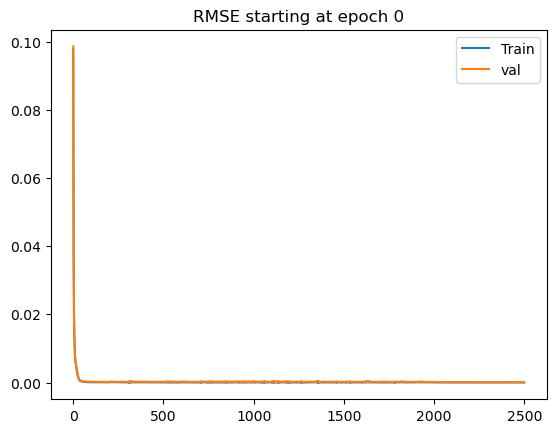

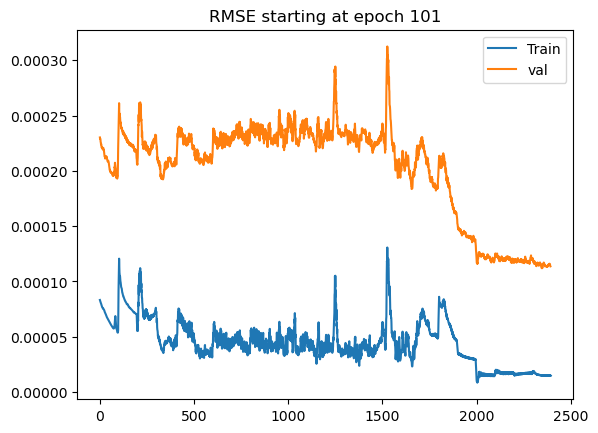

RMSE:  0.0018020562407050353
Network coherency:  0.005194545200913238
Last Layer Coherency Loss:  7.76924640980441
--- alpha 0 ---- lr  0.0008175655252611579----


  4%|▍         | 102/2500 [00:11<04:36,  8.67it/s]

0.004121834498002089
531.2541263421149


  8%|▊         | 202/2500 [00:22<04:19,  8.85it/s]

7.074711864523883e-05
79.10053990245069


 12%|█▏        | 302/2500 [00:34<04:07,  8.87it/s]

0.00018769574425042343
547.175125443392


 16%|█▌        | 402/2500 [00:45<03:56,  8.89it/s]

6.191546200230598e-05
313.8940008254486


 20%|██        | 502/2500 [00:56<03:46,  8.81it/s]

4.2492904182012695e-05
204.90208025652248


 24%|██▍       | 602/2500 [01:07<03:35,  8.79it/s]

5.123549150398392e-05
204.3599903416879


 28%|██▊       | 702/2500 [01:19<03:26,  8.71it/s]

3.283220593770568e-05
189.94473093570494


 32%|███▏      | 802/2500 [01:31<03:12,  8.80it/s]

2.211392930146935e-05
112.73160848196456


 36%|███▌      | 902/2500 [01:42<03:01,  8.79it/s]

1.717756310145651e-05
120.4338834453547


 40%|████      | 1002/2500 [01:54<02:54,  8.59it/s]

1.3287331915486302e-05
88.0943465210364


 44%|████▍     | 1102/2500 [02:05<02:37,  8.87it/s]

1.1279955809943125e-05
93.91609097137955


 48%|████▊     | 1202/2500 [02:18<03:18,  6.55it/s]

9.255002900139239e-06
75.26226636954398


 52%|█████▏    | 1302/2500 [02:30<02:15,  8.85it/s]

7.952939491192573e-06
76.49896635320938


 56%|█████▌    | 1402/2500 [02:41<02:03,  8.86it/s]

6.665170045177336e-06
64.83158734693527


 60%|██████    | 1502/2500 [02:52<01:52,  8.91it/s]

9.131631614189323e-06
76.70689548206047


 64%|██████▍   | 1602/2500 [03:04<01:42,  8.78it/s]

1.0344097712376869e-05
93.2887563514634


 68%|██████▊   | 1702/2500 [03:15<01:30,  8.83it/s]

5.8630709287752175e-06
70.54927257839546


 72%|███████▏  | 1802/2500 [03:26<01:18,  8.94it/s]

5.310690351810382e-06
54.14937744951567


 76%|███████▌  | 1902/2500 [03:38<01:07,  8.81it/s]

4.685366752144968e-06
60.8579524052835


 80%|████████  | 2002/2500 [03:49<00:56,  8.85it/s]

5.285079144353359e-06
51.62619014955114


 84%|████████▍ | 2102/2500 [04:00<00:45,  8.81it/s]

5.2838823486987914e-06
64.17488972823881


 88%|████████▊ | 2202/2500 [04:12<00:34,  8.75it/s]

4.247043770847792e-06
50.214196047389144


 92%|█████████▏| 2302/2500 [04:23<00:28,  6.92it/s]

4.635460211604115e-06
51.49592565793202


 96%|█████████▌| 2402/2500 [04:35<00:11,  8.88it/s]

4.015301758448204e-06
53.391612149991325


100%|██████████| 2500/2500 [04:46<00:00,  8.71it/s]


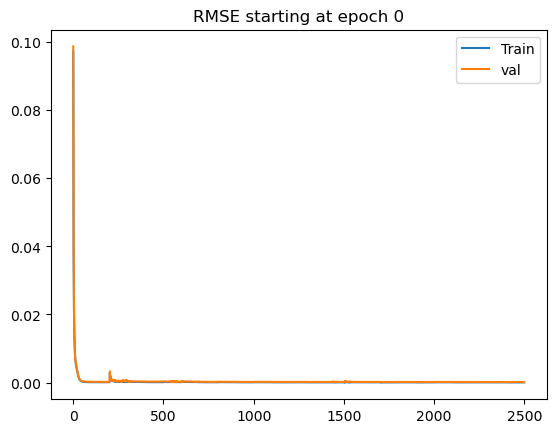

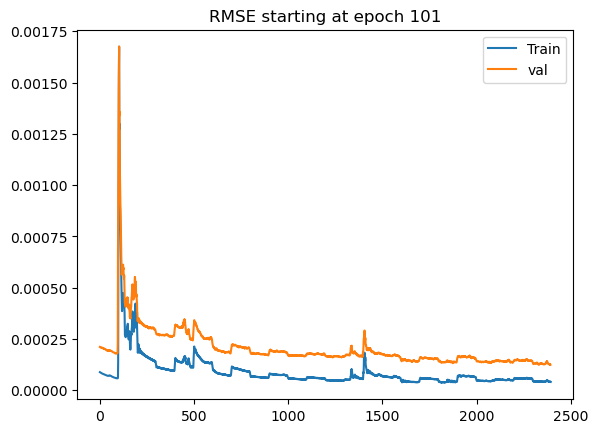

RMSE:  0.001972745422148383
Network coherency:  0.002985247443333069
Last Layer Coherency Loss:  7.428135183103016
--- alpha 0 ---- lr  0.0007115082361212487----


  4%|▍         | 102/2500 [00:11<04:29,  8.91it/s]

0.004340253291125107
537.3245089818188


  8%|▊         | 202/2500 [00:23<04:17,  8.93it/s]

7.214679670212854e-05
77.99782745127061


 12%|█▏        | 302/2500 [00:34<04:20,  8.43it/s]

0.000518316017598909
665.5973651561092


 16%|█▌        | 402/2500 [00:46<03:58,  8.79it/s]

7.714632673060501e-05
264.61750898805326


 20%|██        | 502/2500 [00:57<03:46,  8.82it/s]

5.028708427368106e-05
155.07133204019723


 24%|██▍       | 602/2500 [01:08<03:35,  8.82it/s]

4.061187107943429e-05
174.90762216740777


 28%|██▊       | 702/2500 [01:20<03:22,  8.90it/s]

2.899672904561397e-05
129.94949848835685


 32%|███▏      | 802/2500 [01:31<03:25,  8.28it/s]

2.8825120562022784e-05
128.89989004776768


 36%|███▌      | 902/2500 [01:42<03:00,  8.87it/s]

2.0312188851870995e-05
132.0147585350896


 40%|████      | 1002/2500 [01:54<03:01,  8.27it/s]

1.746571392248864e-05
151.49773089126174


 44%|████▍     | 1102/2500 [02:05<02:37,  8.89it/s]

1.3444535414854873e-05
55.82431639650684


 48%|████▊     | 1202/2500 [02:16<02:26,  8.85it/s]

1.1804987293958426e-05
83.96788776843468


 52%|█████▏    | 1302/2500 [02:28<02:14,  8.89it/s]

9.539179235734957e-06
49.254473668627526


 56%|█████▌    | 1402/2500 [02:39<02:03,  8.91it/s]

9.243375667090132e-06
65.6989910509645


 60%|██████    | 1502/2500 [02:51<01:53,  8.82it/s]

7.641843210095582e-06
47.48832902205046


 64%|██████▍   | 1602/2500 [03:02<01:42,  8.76it/s]

7.456505528089892e-06
53.37338698141953


 68%|██████▊   | 1702/2500 [03:13<01:30,  8.83it/s]

7.48936546881663e-06
47.94563959685167


 72%|███████▏  | 1802/2500 [03:25<01:19,  8.73it/s]

6.425088897181797e-06
51.07239654784303


 76%|███████▌  | 1902/2500 [03:36<01:07,  8.88it/s]

6.535964841988844e-06
41.60435879645885


 80%|████████  | 2002/2500 [03:48<00:56,  8.85it/s]

6.069755284286178e-06
49.899170829909096


 84%|████████▍ | 2102/2500 [03:59<00:46,  8.60it/s]

5.055426740902066e-06
38.67959821201462


 88%|████████▊ | 2202/2500 [04:10<00:33,  8.82it/s]

6.207195727569467e-06
41.26215643874531


 92%|█████████▏| 2302/2500 [04:22<00:22,  8.83it/s]

5.061979581452139e-06
45.56377084574981


 96%|█████████▌| 2402/2500 [04:33<00:11,  8.88it/s]

4.140483811813849e-06
33.47302812443504


100%|██████████| 2500/2500 [04:44<00:00,  8.78it/s]


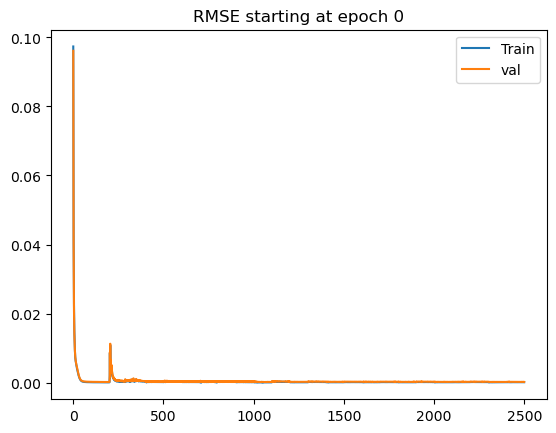

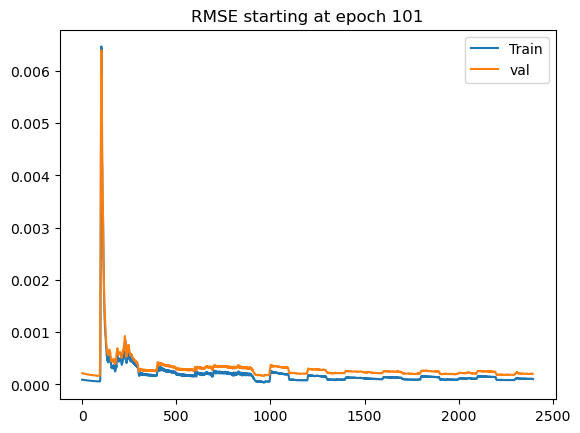

RMSE:  0.001773804070762367
Network coherency:  0.002242448278002168
Last Layer Coherency Loss:  8.912394062834995
--- alpha 0 ---- lr  0.0004438993422676444----


  4%|▍         | 102/2500 [00:11<04:44,  8.44it/s]

0.0056568106424724155
668.7241441006163


  8%|▊         | 202/2500 [00:22<04:24,  8.68it/s]

9.105976981280901e-05
86.71295996606094


 12%|█▏        | 302/2500 [00:34<04:07,  8.88it/s]

0.0008030369676099713
555.9158664060424


 16%|█▌        | 402/2500 [00:45<03:58,  8.79it/s]

0.00044384933267581643
203.471752652595


 20%|██        | 502/2500 [00:56<03:45,  8.84it/s]

0.00024741045716744257
130.29759803167627


 24%|██▍       | 602/2500 [01:08<03:33,  8.87it/s]

0.00025052717207414184
79.61032854773222


 28%|██▊       | 702/2500 [01:20<03:25,  8.74it/s]

0.0005524424811912891
79.13741619896221


 32%|███▏      | 802/2500 [01:31<03:11,  8.85it/s]

0.0023732728588347356
159.26933422087265


 36%|███▌      | 902/2500 [01:42<03:01,  8.80it/s]

0.002254782033293249
74.26373050872564


 40%|████      | 1002/2500 [01:54<02:49,  8.81it/s]

0.0031276721622628284
32.286530530621874


 44%|████▍     | 1102/2500 [02:05<02:51,  8.17it/s]

0.003494172879006358
16.236360339861616


 48%|████▊     | 1202/2500 [02:17<02:27,  8.80it/s]

0.003691465197078533
12.826442504538427


 52%|█████▏    | 1302/2500 [02:28<02:15,  8.86it/s]

0.003816351841742603
11.004090142822351


 56%|█████▌    | 1402/2500 [02:39<02:04,  8.80it/s]

0.0039053891928208123
9.851852227558688


 60%|██████    | 1502/2500 [02:51<01:53,  8.79it/s]

0.003974678963435019
9.168401478294


 64%|██████▍   | 1602/2500 [03:02<01:30,  9.87it/s]

0.004031425725460838
8.450126874496734


 68%|██████▊   | 1702/2500 [03:12<01:27,  9.14it/s]

0.004079524952151402
7.982107681835632


 72%|███████▏  | 1802/2500 [03:23<01:16,  9.09it/s]

0.004121432474657919
7.605676067062823


 76%|███████▌  | 1902/2500 [03:34<01:03,  9.35it/s]

0.004159242681673513
7.310382715856089


 78%|███████▊  | 1938/2500 [03:38<01:08,  8.15it/s]

In [ ]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = False

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('least_squares_scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(2500, batch_size=100, least_squares=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.001/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'least_squares_scaling_increment_batched_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

In [23]:
const_alpha = 100
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        print(scaling_increase_factor)
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_with_alpha_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(2500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.001/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_with_alpha_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

0.1
RMSE:  0.0023106632096146725
Network coherency:  0.0008922724461135985
Last Layer Coherency Loss:  2.203682340313681
0.5
RMSE:  0.0021376095974656524
Network coherency:  0.0006965309876864387
Last Layer Coherency Loss:  0.02647933890071787
1
RMSE:  0.0021845264812925752
Network coherency:  9.320011954161215e-05
Last Layer Coherency Loss:  0.02852570891793473
5
RMSE:  0.002382060149724294
Network coherency:  0.0002638074224972918
Last Layer Coherency Loss:  0.043164361315800794
10
RMSE:  0.0030089504889254993
Network coherency:  0.00028206948378955293
Last Layer Coherency Loss:  0.07422730394420723
50
RMSE:  0.00438899943153856
Network coherency:  0.0002650341438539289
Last Layer Coherency Loss:  0.07205297314862043
0.1
RMSE:  0.0021674616782923002
Network coherency:  0.0011294964587666367
Last Layer Coherency Loss:  2.719580439232503
0.5
RMSE:  0.002343672563038719
Network coherency:  1.0436570944665677e-05
Last Layer Coherency Loss:  0.017158796972997575
1
RMSE:  0.002029675981358

(array([[2.24751079e-03, 2.17593150e-03, 2.05849971e-03, 2.39694103e-03,
         2.91850608e-03, 5.10661486e-03],
        [8.73287711e-04, 3.26745101e-04, 2.59377287e-04, 2.50100596e-04,
         3.01562111e-04, 4.17185485e-04],
        [2.82505573e+00, 2.23244601e-02, 3.41715588e-02, 5.27284906e-02,
         6.12910397e-02, 7.06027869e-02],
        [7.84932030e-03, 7.69860724e-03, 7.78863878e-03, 7.98525110e-03,
         8.16637653e-03, 9.14387602e-03]]),
 array([[6.02963607e-05, 1.12261615e-04, 6.93029431e-05, 1.32986633e-04,
         2.45347237e-04, 7.74920381e-04],
        [1.80490395e-04, 3.04683442e-04, 1.67825905e-04, 1.35717566e-04,
         1.80494227e-04, 2.12257160e-04],
        [6.13059241e-01, 5.16099311e-03, 1.15558195e-02, 1.05696901e-02,
         1.12491815e-02, 6.85352734e-03],
        [1.14067648e-04, 8.21051867e-05, 1.12319968e-04, 9.46713830e-05,
         2.17617169e-04, 3.76204620e-04]]))

In [29]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        print(scaling_increase_factor)
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(2500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.001/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

0.1
RMSE:  0.003497997455596559
Network coherency:  0.004031721757954442
Last Layer Coherency Loss:  0.5187879222891308
0.5
RMSE:  0.0033128931790018176
Network coherency:  0.005228307009616326
Last Layer Coherency Loss:  0.12087495454604173
1
RMSE:  0.0051378742626916425
Network coherency:  0.044776762174138646
Last Layer Coherency Loss:  0.1675241881627145
5
RMSE:  0.003019749450243789
Network coherency:  0.018993127913043334
Last Layer Coherency Loss:  0.12019799667750995
10
RMSE:  0.004596645615122661
Network coherency:  0.042063800216824244
Last Layer Coherency Loss:  0.1746200163481518
50
RMSE:  0.003570685879579484
Network coherency:  0.001416320129574573
Last Layer Coherency Loss:  0.07265742627978132
0.1
RMSE:  0.0030498579451721524
Network coherency:  0.019360082281297333
Last Layer Coherency Loss:  0.47490359127902637
0.5
RMSE:  0.0019804453499268097
Network coherency:  0.0012200449060528183
Last Layer Coherency Loss:  0.2233639616063952
1
RMSE:  0.00312994746088599
Network 

(array([[0.00293881, 0.00254175, 0.00386713, 0.00288343, 0.00365345,
         0.00449008],
        [0.00688924, 0.00213336, 0.02455694, 0.00791435, 0.00869705,
         0.00073811],
        [0.30266394, 0.12947466, 0.21413405, 0.07512341, 0.08995424,
         0.07001233],
        [0.00947074, 0.00929216, 0.01131211, 0.00946302, 0.00943555,
         0.00943214]]),
 array([[0.00053828, 0.00051155, 0.00113881, 0.00091247, 0.00109839,
         0.00068821],
        [0.00735216, 0.00198045, 0.02080491, 0.00941593, 0.01668429,
         0.00040042],
        [0.1883029 , 0.09619834, 0.08894808, 0.04095419, 0.04826177,
         0.00549982],
        [0.00136076, 0.00143112, 0.00054172, 0.00233308, 0.00173579,
         0.00065837]]))

In [30]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.00293881 0.00254175 0.00386713 0.00288343 0.00365345 0.00449008]
[0.00053828 0.00051155 0.00113881 0.00091247 0.00109839 0.00068821]
validation
[0.00947074 0.00929216 0.01131211 0.00946302 0.00943555 0.00943214]
[0.00136076 0.00143112 0.00054172 0.00233308 0.00173579 0.00065837]
coherency
[0.00688924 0.00213336 0.02455694 0.00791435 0.00869705 0.00073811]


In [25]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
proj_inc_trained = True

metrics_project_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if proj_inc_trained: 
            network = load_model('projection_inc_batched_{inc}_trial={i}.pth.pth'.format(inc=scaling_increase_factor, i=i), True)
        else: 
            network, loss = train_net(2500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=True,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'projection_inc_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_project_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        
        scaling_idx += 1

metrics_project_increment.mean(axis=1), metrics_project_increment.std(axis=1)

RMSE:  0.003914066487751863
Network coherency:  7.46963160369162e-10
Last Layer Coherency Loss:  0.9350606901589984
RMSE:  0.004775395785566927
Network coherency:  7.977674600230575e-10
Last Layer Coherency Loss:  0.9700672338356451
RMSE:  0.003766507339758856
Network coherency:  7.727042881943963e-10
Last Layer Coherency Loss:  1.0336947048812877
RMSE:  0.003057553932941517
Network coherency:  9.59071918518535e-10
Last Layer Coherency Loss:  1.0075816909632658
RMSE:  0.003814068096312295
Network coherency:  1.349091036479469e-09
Last Layer Coherency Loss:  0.5458716124380099
RMSE:  0.0025836321243155247
Network coherency:  7.341531799931768e-10
Last Layer Coherency Loss:  0.4028956093600749
RMSE:  0.005180125784363813
Network coherency:  7.658009679237049e-10
Last Layer Coherency Loss:  0.9883880549428281
RMSE:  0.0037629947471528986
Network coherency:  7.225039671555152e-10
Last Layer Coherency Loss:  0.8406454714129105
RMSE:  0.009423381729142507
Network coherency:  7.43559227704813

(array([[4.34996812e-03, 4.20558271e-03, 5.65975308e-03, 3.21621560e-03,
         3.16720567e-03, 3.03100371e-03],
        [7.55227785e-10, 7.73968701e-10, 7.60017228e-10, 9.03653850e-10,
         9.93120970e-10, 7.83009801e-10],
        [7.51029609e-01, 8.81467083e-01, 9.05951133e-01, 6.88559980e-01,
         6.38808345e-01, 3.75720655e-01],
        [8.15229093e-03, 8.29245736e-03, 9.62393288e-03, 9.29885669e-03,
         1.02968467e-02, 1.06005621e-02]]),
 array([[1.01733445e-03, 6.49737861e-04, 2.01982712e-03, 5.80596175e-04,
         3.98702391e-04, 2.55888762e-04],
        [2.68849666e-11, 5.02261218e-11, 3.92546442e-11, 1.42420447e-10,
         2.34251496e-10, 3.71873405e-11],
        [2.03716680e-01, 1.19708459e-01, 3.45956339e-01, 2.17793171e-01,
         1.49416558e-01, 4.05319149e-02],
        [6.64208512e-04, 3.89738031e-04, 1.15183556e-03, 5.08873619e-04,
         4.19755676e-04, 3.91480080e-04]]))

In [27]:
print('test')
print(metrics_project_increment.mean(axis=1)[0, :])
print(metrics_project_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_project_increment.mean(axis=1)[3, :])
print(metrics_project_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_project_increment.mean(axis=1)[1, :])

test
[0.00434997 0.00420558 0.00565975 0.00321622 0.00316721 0.003031  ]
[0.00101733 0.00064974 0.00201983 0.0005806  0.0003987  0.00025589]
validation
[0.00815229 0.00829246 0.00962393 0.00929886 0.01029685 0.01060056]
[0.00066421 0.00038974 0.00115184 0.00050887 0.00041976 0.00039148]
coherency
[7.55227785e-10 7.73968701e-10 7.60017228e-10 9.03653850e-10
 9.93120970e-10 7.83009801e-10]


In [24]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for alpha in alpha_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('alpha_{alpha}_trial={i}.pth'.format(alpha=alpha, i=i), False)
        else: 
            network, loss = train_net(2500, batch_size=100, coherent=True, alpha=alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=0, 
                                 lr=0.005/(1 + np.log(1+alpha)), plot_loss=True)
            save_model(network, 'alpha_{alpha}_trial={i}'.format(alpha=alpha, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

RMSE:  0.0022163895938767768
Network coherency:  0.003646809275779179
Last Layer Coherency Loss:  0.893825608925258
RMSE:  0.002388523539249783
Network coherency:  0.001872301441822955
Last Layer Coherency Loss:  0.3118915937083468
RMSE:  0.002877176476014079
Network coherency:  0.006979487700685254
Last Layer Coherency Loss:  0.2777899753295544
RMSE:  0.003319514963133492
Network coherency:  0.004045622733392013
Last Layer Coherency Loss:  0.12539180428248636
RMSE:  0.0046377524137637795
Network coherency:  0.0038540916505027246
Last Layer Coherency Loss:  0.11367349788895495
RMSE:  0.004545276303718962
Network coherency:  0.002811806971025199
Last Layer Coherency Loss:  0.11933182267696917
RMSE:  0.00408672600621262
Network coherency:  0.010731821502849473
Last Layer Coherency Loss:  0.14468824624785748
RMSE:  0.003158548518844709
Network coherency:  0.005469647651021616
Last Layer Coherency Loss:  1.1706307724439833
RMSE:  0.003006031310155327
Network coherency:  0.00914572019960021

(array([[0.00431058, 0.00368531, 0.00317849, 0.00586464, 0.00751815,
         0.00770079, 0.00814617],
        [0.01754572, 0.02361032, 0.00891906, 0.01135812, 0.00288452,
         0.00172493, 0.00324477],
        [1.2429943 , 1.03061286, 0.90237368, 0.64202468, 0.30747399,
         0.20175251, 0.18050704],
        [0.0080045 , 0.00772775, 0.0082816 , 0.01324583, 0.01171495,
         0.01227048, 0.01073162]]),
 array([[1.84056450e-03, 1.11482710e-03, 1.82911210e-04, 1.40215578e-03,
         1.47143470e-03, 1.60620860e-03, 2.03565773e-03],
        [2.29297456e-02, 2.10404136e-02, 2.60909889e-03, 6.84243447e-03,
         1.58564567e-03, 7.68803169e-04, 3.80863743e-03],
        [2.36703545e-01, 3.76025576e-01, 3.56158199e-01, 2.62190299e-01,
         9.91710236e-02, 4.38993676e-02, 3.32847163e-02],
        [6.97238924e-04, 5.66590513e-04, 5.91721799e-04, 1.77548806e-03,
         1.44600885e-03, 6.77251290e-04, 7.93842733e-05]]))

In [26]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.00431058 0.00368531 0.00317849 0.00586464 0.00751815 0.00770079
 0.00814617]
[0.00184056 0.00111483 0.00018291 0.00140216 0.00147143 0.00160621
 0.00203566]
validation
[0.0080045  0.00772775 0.0082816  0.01324583 0.01171495 0.01227048
 0.01073162]
[6.97238924e-04 5.66590513e-04 5.91721799e-04 1.77548806e-03
 1.44600885e-03 6.77251290e-04 7.93842733e-05]
coherency
[0.01754572 0.02361032 0.00891906 0.01135812 0.00288452 0.00172493
 0.00324477]


In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_scale_increment = [train_net(10000, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, 
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1 + scaling_increase_factor/4)), 
                                      plot_loss=True) for scaling_increase_factor in [10]]

get_metrics(networks_scale_increment, verbose=True)

In [ ]:
mean_rmses_if = np.mean(metrics_increment[0], axis=0)
std_rmses_if = np.std(metrics_increment[0], axis=0)

print(mean_rmses_if)
print(std_rmses_if) 

mean_network_coherencies_if = np.mean(metrics_increment[1], axis=0)
std_network_coherencies_if = np.std(metrics_increment[1], axis=0)

mean_ll_losses_if = np.mean(metrics_increment[2], axis=0)
std_ll_losses_if = 2*np.std(metrics_increment[2], axis=0)

print(mean_network_coherencies_if)
print(std_network_coherencies_if) 

# Calculate mean and std for baseline and projection metrics
mean_metrics_baseline = np.mean(baseline_metrics, axis=1)
std_metrics_baseline = 2*np.std(baseline_metrics, axis=1)

mean_metrics_projection = np.mean(projection_metrics, axis=1)
std_metrics_projection = 2*np.std(projection_metrics, axis=1)

print(mean_metrics_baseline)
print(std_metrics_baseline)
print(mean_metrics_projection)
print(std_metrics_projection) 

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))

# RMSE plot with error bars
ax1.set_title('RMSE vs alpha scaling increment')
ax1.errorbar(alpha_scale_increment_experiments, mean_rmses_if, yerr=std_rmses_if, fmt='o', label='Incremental')
ax1.axhline(mean_metrics_baseline[0], color='red', label='Baseline', linestyle='--')
ax1.axhline(mean_metrics_projection[0], color='blue', label='Projection', linestyle='--')
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_baseline[0]-std_metrics_baseline[0], mean_metrics_baseline[0]+std_metrics_baseline[0], color='red', alpha=0.2)
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_projection[0]-std_metrics_projection[0], mean_metrics_projection[0]+std_metrics_projection[0], color='blue', alpha=0.2)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('Alpha')
ax1.legend()

# Network coherency plot with error bars
ax2.set_title('Coherency on data vs alpha, incremental')
ax2.errorbar(alpha_scale_increment_experiments, mean_network_coherencies_if, yerr=std_network_coherencies_if, fmt='o')
ax2.set_ylabel('Coherency on data')
ax2.set_xlabel('Alpha')

# Last layer coherency plot with error bars
ax3.errorbar(alpha_scale_increment_experiments, mean_ll_losses_if, yerr=std_ll_losses_if, fmt='o')
ax3.set_ylabel('Last layer coherency')
ax3.set_xlabel('Alpha')

plt.tight_layout()
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_project = [train_net(6000, coherent=True, alpha=0, alpha_scaling=0, should_project=True, plot_loss=True,
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1+scaling_increase_factor/4))) for scaling_increase_factor in alpha_scale_increment_experiments]

get_metrics(networks_project, verbose=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))
ax1.set_title('metrics vs alpha scaling increment with projection')
ax1.scatter(alpha_scale_experiments, rmses_if)
ax1.axhline(rmse_baseline, color='red', label='baseline')
ax1.axhline(rmse_projection, color='green', label='projection')
ax1.set_ylabel('rmse')
ax1.set_xlabel('alpha')
ax1.legend()
#ax2.set_title('coherency on data vs alpha, no scaling and no scaling increment')
ax2.scatter(alpha_scale_experiments, network_coherencies_if)
ax2.set_ylabel('coherency on data')
ax2.set_xlabel('alpha')
#ax3.set_title('last layer coherency vs alpha, no scaling and no scaling increment')
ax3.scatter(alpha_scale_experiments, ll_losses_if)
ax3.set_ylabel('last layer coherency')
ax3.set_xlabel('alpha')
plt.show()

In [ ]:
#network, losses = train_net(1000, coherent=False) 
#network_coherent, losses_coherent = train_net(1000, coherent=True, alpha=0)
#network_coherent_high_scaling, losses_coherent_high_scaling = train_net(1000, coherent=True, alpha=0.25, alpha_scaling=1)
network_projection, losses_projection = train_net(5000, should_project=True)
#network_coherent_and_projecting, losses_projection_high_scaling = train_net(1000, coherent=True, alpha=0.5, alpha_scaling=1, should_project=True)

In [ ]:
plt.plot(range(len(losses_projection[100:])), losses_projection[100:], label='projection')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.figure()
#plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
#plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
#plt.legend() 

In [ ]:
rmse_projection = calculate_mean_RMSE(network_projection)
rmse_projection

In [ ]:
rmse_projection = 0.0032 

In [ ]:
network_baseline, losses_baseline = train_net(2000, coherent=False)

In [ ]:
rmse_baseline = calculate_mean_RMSE(network_baseline)
rmse_baseline

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Labour Dataset')

# First Set of Data
axs[0, 0].set_title('Alpha Experiments (No Scaling and No Scaling Increment)')
axs[0, 0].scatter(alpha_experiments, rmses)
axs[0, 0].set_ylabel('rmse')
axs[0, 0].set_xlabel('alpha')
axs[0, 0].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 0].axhline(rmse_projection, color='green', label='projection')
axs[0, 0].legend()

axs[1, 0].scatter(alpha_experiments, network_coherencies)
axs[1, 0].set_ylabel('coherency on data')
axs[1, 0].set_xlabel('alpha')
axs[1, 0].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 0].legend()

axs[2, 0].scatter(alpha_experiments, ll_losses)
axs[2, 0].set_ylabel('last layer coherency')
axs[2, 0].set_xlabel('alpha')

# Second Set of Data
axs[0, 1].set_title('Alpha Scaling Experiments (Constant alpha = 0)')
axs[0, 1].scatter(alpha_scale_experiments, rmses_s)
axs[0, 1].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 1].axhline(rmse_projection, color='green', label='projection')
axs[0, 1].set_ylabel('rmse')
axs[0, 1].set_xlabel('alpha scaling')
axs[0, 1].legend()

axs[1, 1].scatter(alpha_scale_experiments, network_coherencies_s)
axs[1, 1].set_ylabel('coherency on data')
axs[1, 1].set_xlabel('alpha scaling')
axs[1, 1].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 1].legend()

axs[2, 1].scatter(alpha_scale_experiments, ll_losses_s)
axs[2, 1].set_ylabel('last layer coherency')
axs[2, 1].set_xlabel('alpha scaling')

# Third Set of Data
axs[0, 2].set_title('Scaling Increment Experiments (Constant alpha = 0, scaling = 0)')
axs[0, 2].scatter(alpha_scale_increment_experiments, rmses_if)
axs[0, 2].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 2].axhline(rmse_projection, color='green', label='projection')
axs[0, 2].set_ylabel('rmse')
axs[0, 2].set_xlabel('alpha increment')
axs[0, 2].legend()

axs[1, 2].scatter(alpha_scale_increment_experiments, network_coherencies_if)
axs[1, 2].set_ylabel('coherency on data')
axs[1, 2].set_xlabel('alpha increment')
axs[1, 2].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 2].legend()

axs[2, 2].scatter(alpha_scale_increment_experiments, ll_losses_if)
axs[2, 2].set_ylabel('last layer coherency')
axs[2, 2].set_xlabel('alpha increment')

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
axs[1,2].set_xscale('log')
axs[2,0].set_xscale('log')
axs[2,1].set_xscale('log')
axs[2,2].set_xscale('log')

plt.tight_layout()
plt.savefig('parameter_experiments_traffic.png')
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_increment_scaled = [train_net(4000, coherent=True, alpha=0, alpha_scaling=0, should_project=True,
                            scaling_increase_factor=scaling_increase_factor + 0.1, lr=0.005/(1 + np.log(1+scaling_increase_factor))) for scaling_increase_factor in alpha_scale_experiments]

get_metrics(networks_increment_scaled, verbose=True)

In [ ]:
# TODO: implement a function that chooses alpha based on the best training data and hopefully show that the selected alpha also performs well on test data

def test_best_alpha(networks):

    train_rmses = [] 
    test_rmses = [] 

    for network, _ in networks: 

        network.lstm.eval() 
        train_rmse = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        test_rmse = calculate_RMSE(y_test.numpy(), network(X_test.to(device)).detach().cpu().numpy())

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    return train_rmses, test_rmses

In [ ]:
train_rmses, test_rmses = test_best_alpha(networks_scale_increment)
#train_rmses_scaled, test_rmses_scaled = test_best_alpha(networks_increment_scaled)
# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(train_rmses, test_rmses)

plt.axhline(rmse_projection, color='green', label='projection')
plt.axhline(rmse_baseline, color='red', label='baseline')

# Annotate each point with its label
for i, label in enumerate(alpha_scale_increment_experiments):
    plt.annotate(label, (train_rmses[i], test_rmses[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize the plot
plt.title('Test RMSE vs. Validation RMSE. Labels are Alpha Scaling Increment Values')
plt.xlabel('Validation RMSE')
plt.ylabel('Test RMSE')

# # Set custom axis limits
# plt.xlim(0.0010, 0.0013)
# plt.ylim(0.004, 0.0055)

# Show the plot
plt.legend() 
plt.savefig('val_traffic.png')
plt.show()

In [ ]:
test_best_alpha(networks)

In [ ]:
# plot losses for learning
#plt.plot(range(len(losses[100:])), losses[100:], label='base')
plt.plot(range(len(losses_projection[100:1000])), losses_projection_high_scaling[100:1000], label='projection')
plt.legend()
plt.show()
plt.figure()
plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
plt.legend() 

In [ ]:
# printing the real coherency of each network we trained
print("baseline network coherency", coherency_metric(network(X_test)).item())
print("coherent network coherency", coherency_metric(network_coherent(X_test)).item())
print("coherent network coherency (high scaling)", coherency_metric(network_coherent_high_scaling(X_test)).item())
#print("projection network coherency", coherency_metric(network_projection(X_test)).item())
#print("both coherency", coherency_metric(network_coherent_and_projecting(X_test)).item())

# Visualizations

In [19]:
def plot_loss(losses, validation_loss, title='', l2s=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Set up a figure with two subplots (axes)
    
    # Plot MSE Loss on the first axis
    axs[0].plot(losses, label='Train')
    axs[0].plot(validation_loss, label='Validation')
    axs[0].set_title(title + ' MSE Loss vs Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('MSE Loss')
    axs[0].set_yscale('log')
    axs[0].legend()

    if l2s:
        # Plot Coherency Loss on the second axis if l2s is provided
        axs[1].plot(l2s, label='Coherency Loss')
        axs[1].set_title(title + ' Coherency Loss vs Epoch')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Coherency Loss')
        axs[1].set_yscale('log')
        axs[1].legend()

    plt.tight_layout()
    plt.savefig('figs/' + title + '.png')
    plt.show()  

In [36]:
network_alpha, l1s_alpha, l2s_alpha, val_alpha = train_net(2500, batch_size=100, coherent=True, alpha=1, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=0, 
                                 lr=0.005, plot_loss=True)

--- alpha 1 ---- lr  0.005----


 13%|█▎        | 313/2500 [00:22<02:36, 13.98it/s]


KeyboardInterrupt: 

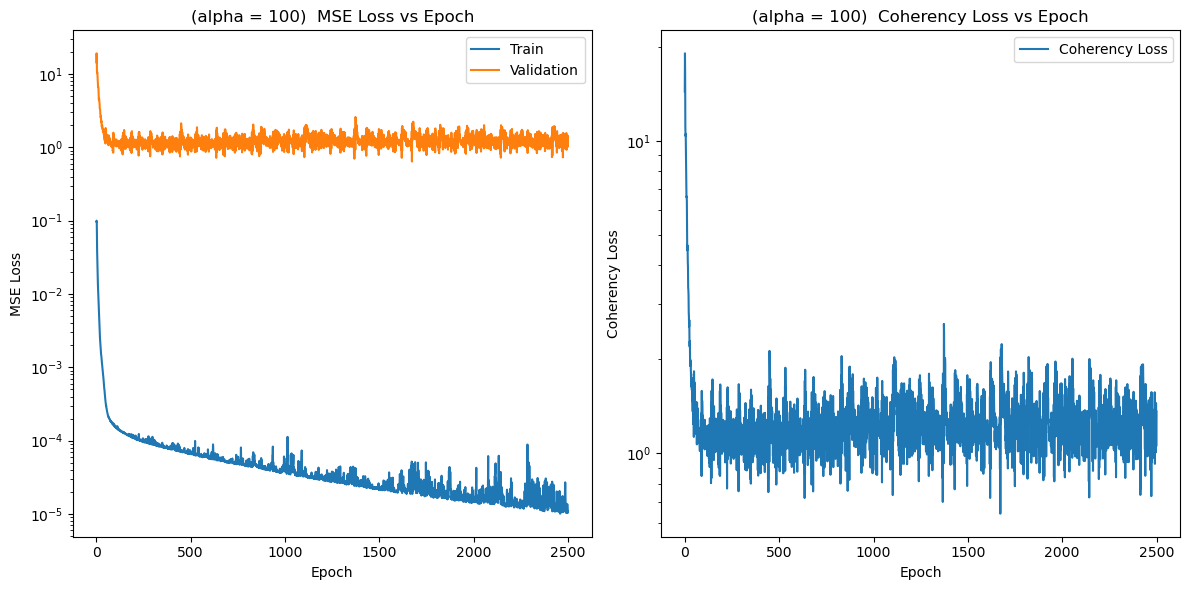

In [21]:
plot_loss(l1s_alpha, val_alpha, l2s=l2s_alpha, title = '(alpha = 100) ')

In [40]:
network_alpha_and_increment, l1s_alpha_and_increment, l2s_alpha_and_increment, val_alpha_and_incrmeent = train_net(2500, batch_size=100, coherent=True, 
                                                                                                        alpha=100, alpha_scaling=0, should_project=False, 
                                                                                                                   scaling_increase_factor=1, lr=0.001, plot_loss=True)

--- alpha 100 ---- lr  0.001----


  4%|▍         | 102/2500 [00:07<02:51, 14.00it/s]

0.00643604608858522
1.2755788980463378
14.36906184411466


  8%|▊         | 202/2500 [00:14<02:44, 13.95it/s]

0.0006309646477766107
3.5350117405803188
3.9650931800981235


 10%|▉         | 247/2500 [00:17<02:42, 13.86it/s]


KeyboardInterrupt: 

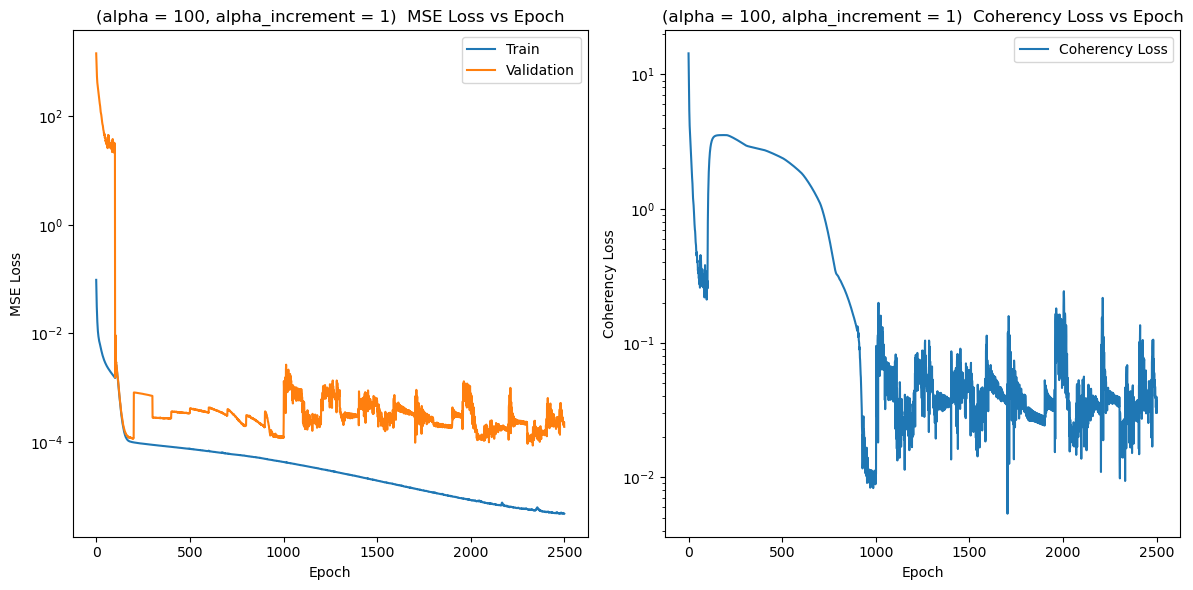

In [23]:
plot_loss(l1s_alpha_and_increment, val_alpha_and_incrmeent, l2s=l2s_alpha_and_increment, title = '(alpha = 100, alpha_increment = 1) ')

--- alpha 0 ---- lr  0.0025----


100%|██████████| 2500/2500 [03:01<00:00, 13.74it/s]


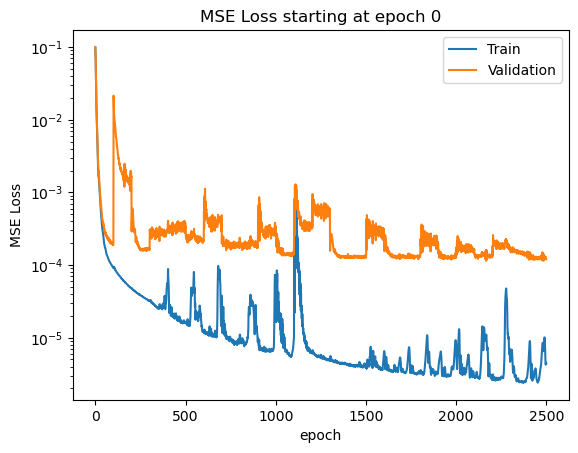

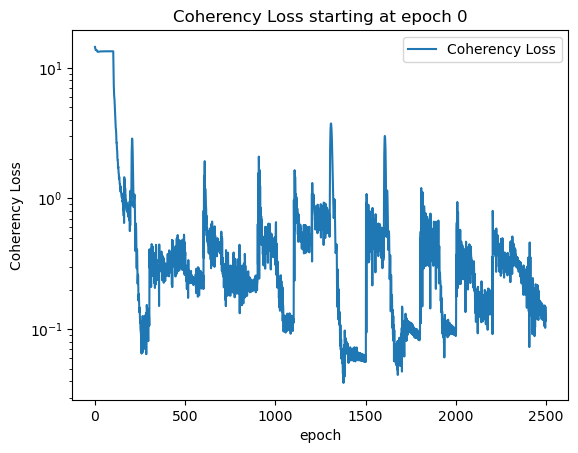

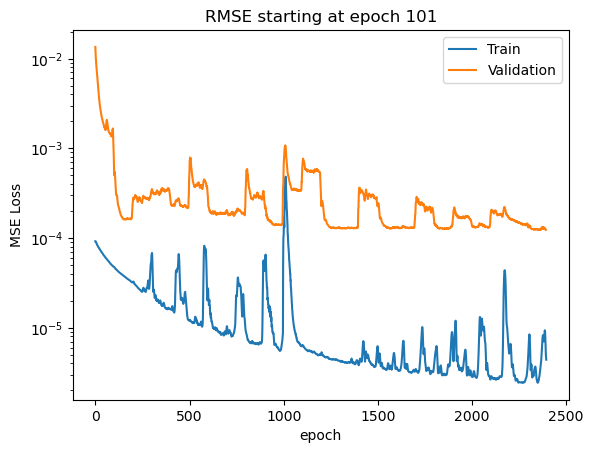

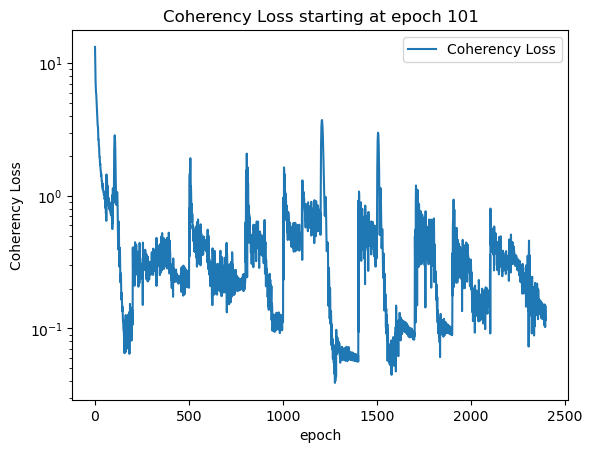

In [24]:
network_alpha_scaling, l1_alpha_scaling, l2_alpha_scaling, val_alpha_scaling = train_net(2500, batch_size=100, coherent=True, alpha=0, alpha_scaling=5, should_project=False,
                                 scaling_increase_factor=0, 
                                 lr=0.0025, plot_loss=True)

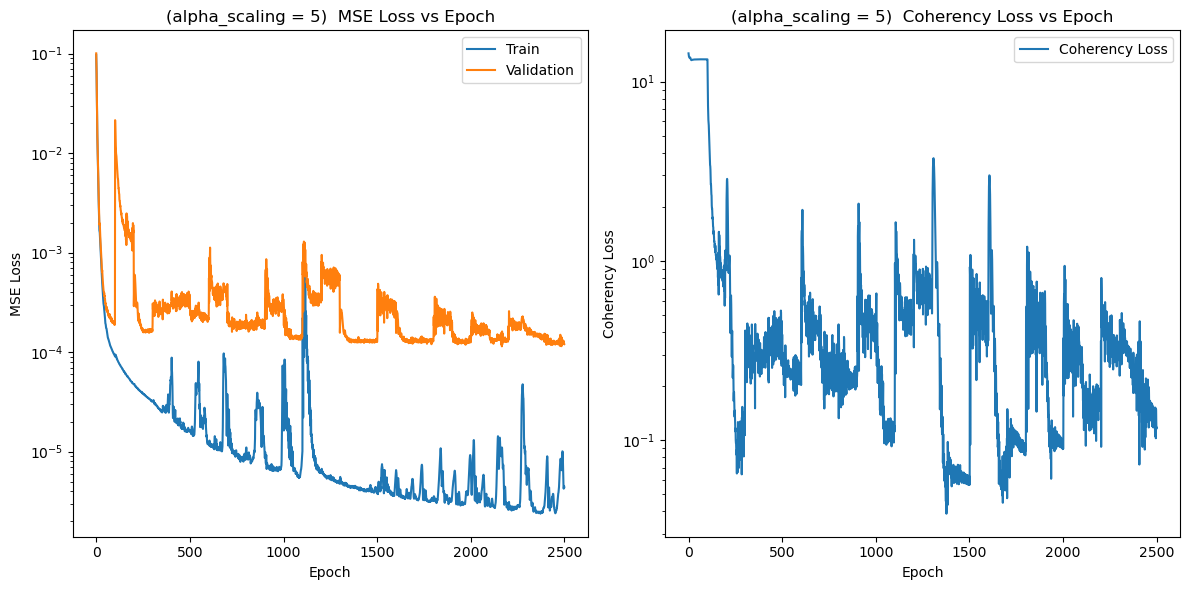

In [25]:
plot_loss(l1_alpha_scaling, val_alpha_scaling, l2s=l2_alpha_scaling, title = '(alpha_scaling = 5) ')

In [26]:
print(get_metrics([network_alpha_scaling]))
print(get_metrics([network_alpha_and_increment]))

([0.002972437966059003], [0.0004242984104851679], [0.12754162068597963])
([0.002178225931008383], [0.00031318525245756376], [0.044244092965921036])


--- alpha 0 ---- lr  0.005----


100%|██████████| 2500/2500 [03:04<00:00, 13.58it/s]


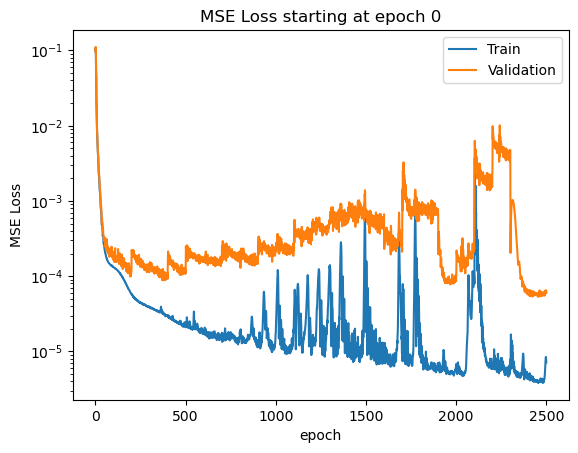

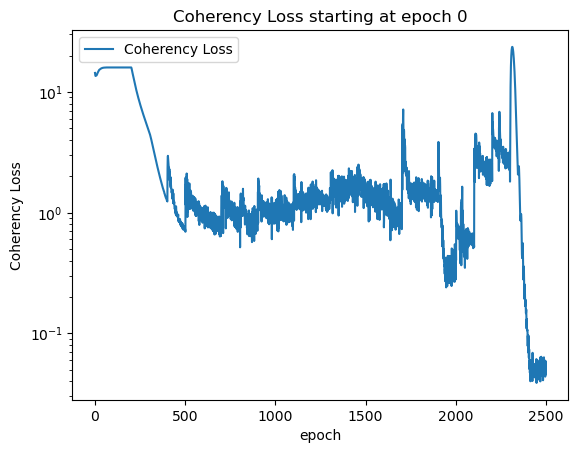

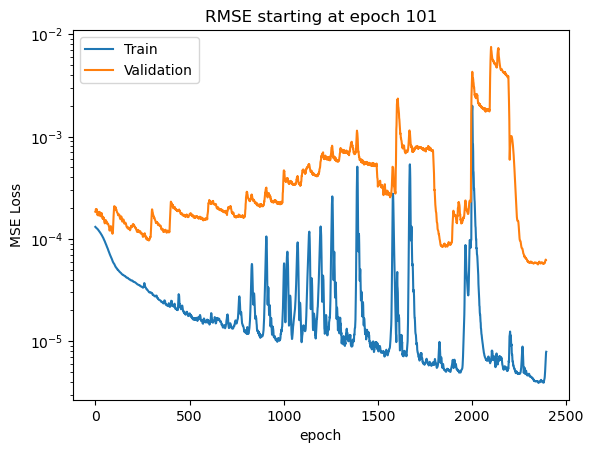

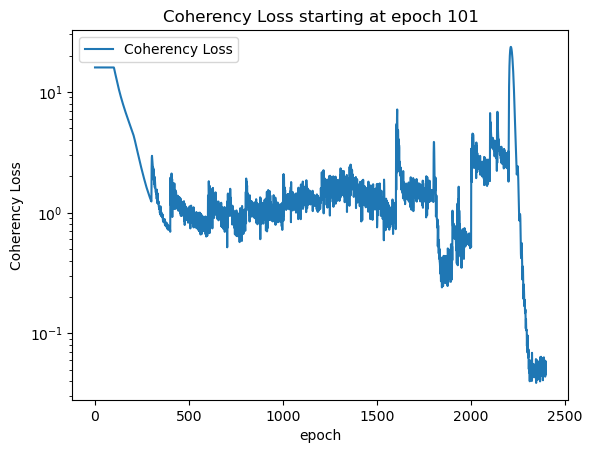

In [27]:
network_alpha_increment, l1_alpha_increment, l2_alpha_increment, val_alpha_increment = train_net(2500, batch_size=100, coherent=True, alpha=0, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=1, 
                                 lr=0.005, plot_loss=True)

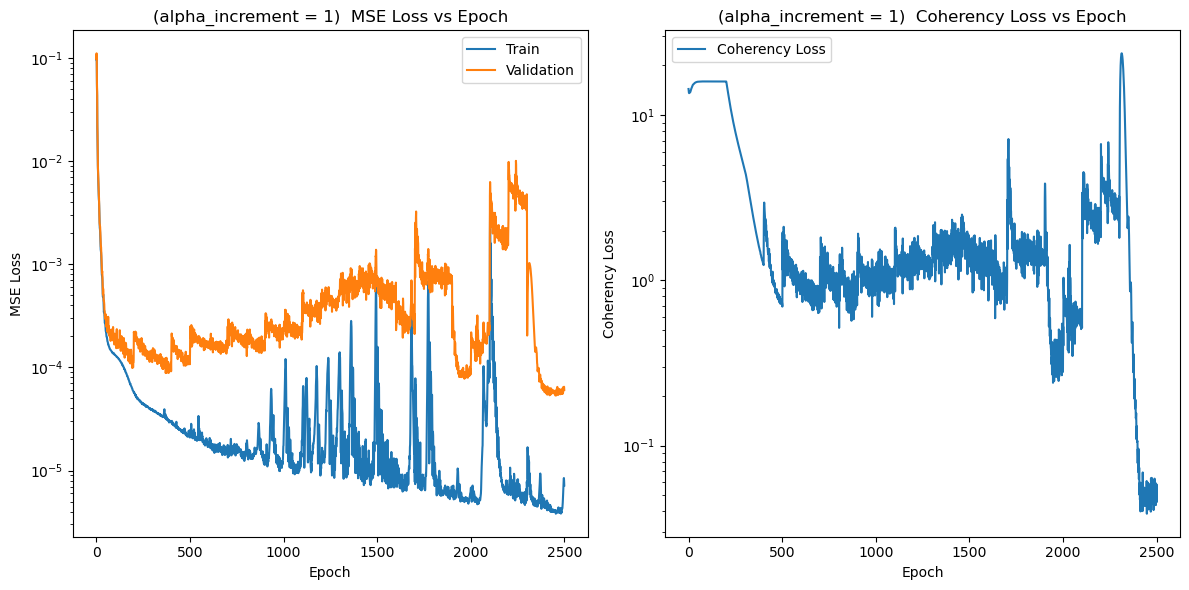

In [28]:
plot_loss(l1_alpha_increment, val_alpha_increment, l2s=l2_alpha_increment, title = '(alpha_increment = 1) ')

--- alpha 0 ---- lr  0.005----


100%|██████████| 2500/2500 [02:59<00:00, 13.93it/s]


ValueError: x and y must have same first dimension, but have shapes (0,) and (2500,)

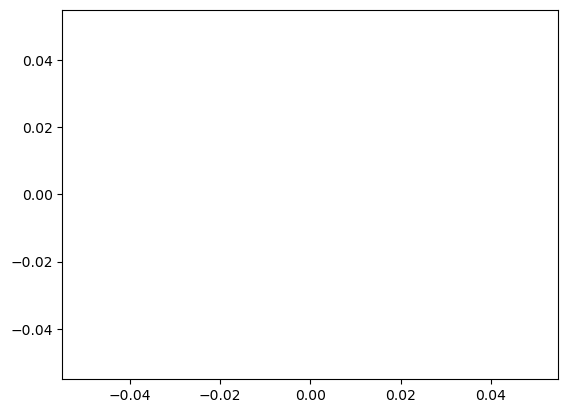

In [29]:
network_baseline, l1_baseline, l2_baseline, val_baseline = train_net(2500, batch_size=100, coherent=False, alpha=0, alpha_scaling=0, should_project=False,
                                 scaling_increase_factor=0, 
                                 lr=0.005, plot_loss=True)

In [ ]:
network_projection, loss_projection = train_net(2500, batch_size=100, coherent=False, alpha=0, alpha_scaling=0, should_project=True,
                                 scaling_increase_factor=0, 
                                 lr=0.005, plot_loss=True)

In [ ]:
visualize(0, [network, network_coherent, network_projection], ['baseline', 'coherent loss', 'projection'])

In [30]:
all_agg_levels = np.unique([torch.sum(aggregation_mat[ts,:]).item() for ts in range(len(aggregation_mat))])

In [31]:
all_agg_levels

array([  1.,  50., 100., 200.])

Baseline: 0.00036948482616756194
Coherent: 0.00023662101045582429


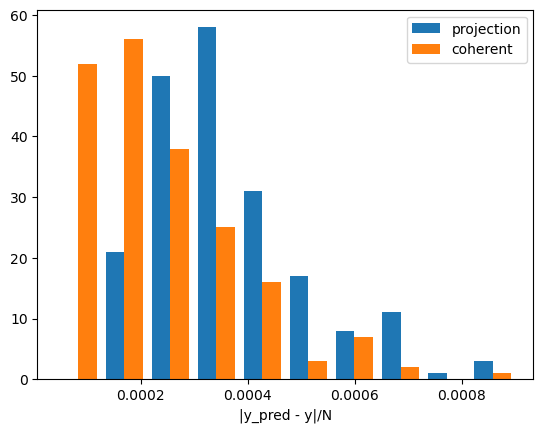

In [34]:
# this code plots the error 

aggregation_level = all_agg_levels[0]
aggregation_amounts = []
errs_baseline = [] 
errs_coherent = []
for ts in range(len(aggregation_mat)):
    agg_level = torch.sum(aggregation_mat[ts,:]).item()
    if agg_level == aggregation_level: 
        err_baseline = torch.norm(network_alpha(X_test.to(device)).cpu()[:,ts] - y_test[:,ts]).item() / len(X_test)
        err_coherent = torch.norm(network_alpha_scaling(X_test.to(device)).cpu()[:,ts] - y_test[:,ts]).item() / len(X_test)

        aggregation_amounts.append(agg_level)
        errs_baseline.append(err_baseline)
        errs_coherent.append(err_coherent)

plt.hist([errs_baseline, errs_coherent], label = ['projection', 'coherent'])

print("Baseline:", np.mean(errs_baseline))
print("Coherent:", np.mean(errs_coherent))

plt.xlabel('|y_pred - y|/N')
plt.legend()